In [ ]:
import pandas as pd
import numpy as np

df_lsoa = pd.read_parquet("../data/processed/census_lsoa.parquet")

lookup = pd.read_csv(
    "../data/lookups/look up LSOA 2021 to ward 2024 merged.csv",
    usecols=["LSOA21CD", "WD24CD", "WD24NM"]
)

# Mege on LSOA code
df_lsoa = df_lsoa.merge(
    lookup,
    left_on="LSOA code",
    right_on="LSOA21CD",
    how="inner"
)
df_ward_census = (
    df_lsoa
    .groupby(["WD24CD", "WD24NM"], as_index=False)
    .agg({"Total: All dwellings": "sum"})
)
df_ward_census.rename(
    columns={
        "WD24CD": "Ward code",
        "WD24NM": "Ward name",
        "Total: All dwellings": "Dwellings"
    },
    inplace=True
)

sarima_fc = pd.read_csv(
    "../data/processed/sarima_final_forecast_per_ward.csv",
    parse_dates=["Month"]
)
first_fc_month = sarima_fc["Month"].min()
fc1 = sarima_fc[sarima_fc["Month"] == first_fc_month].copy()

df = (
    fc1[["Ward code", "Ward name", "mean"]]
    .merge(
        df_ward_census[["Ward code", "Dwellings"]],
        on="Ward code",
        how="left"
    )
    .rename(columns={"mean": "Forecasted_Burglaries"})
)

df["Risk_Rate"] = df["Forecasted_Burglaries"] / df["Dwellings"].replace(0, np.nan)
df["Risk_Rate"] = df["Risk_Rate"].clip(lower=0)

r_max = df["Risk_Rate"].max()

df["Allocated_Hours"] = 200 * (df["Risk_Rate"] / r_max)
df["Allocated_Hours"] = df["Allocated_Hours"].clip(lower=2)

df["Allocated_Hours"] = df["Allocated_Hours"].round(0) # Integer hours
df = df.sort_values("Allocated_Hours", ascending=False).reset_index(drop=True)

print(df[[
    "Ward code",
    "Ward name",
    "Dwellings",
    "Risk_Rate",
    "Allocated_Hours"
]])

df.to_csv("../data/processed/ward_hour_allocation.csv", index=False)


     Ward code                 Ward name  Dwellings     Risk_Rate  \
0    E05013662   Holborn & Covent Garden       5985  4.385889e-03   
1    E05013748     Shepherd's Bush Green       3080  4.309465e-03   
2    E09000001            City of London       7330  3.821007e-03   
3    E05009377  Hoxton East & Shoreditch       6410  3.821176e-03   
4    E05013808                  West End      10270  3.786360e-03   
..         ...                       ...        ...           ...   
675  E05009368                  Cazenove       5300  0.000000e+00   
676  E05013883                   Cathall       4310  0.000000e+00   
677  E05013945                  Tolworth       4755  4.669708e-19   
678  E05013578             Ruislip Manor       3920  0.000000e+00   
679  E05013617            Heston Central       4485  0.000000e+00   

     Allocated_Hours  
0              200.0  
1              197.0  
2              174.0  
3              174.0  
4              173.0  
..               ...  
675       

In [17]:
import pandas as pd
from gurobipy import Model, GRB

# Total hours available across all wards
allocation_simple_method = pd.read_csv("../data/processed/ward_hour_allocation.csv")
total_officers_hours = allocation_simple_method["Allocated_Hours"].sum()

file_path = "../data/processed/sarima_final_forecast_per_ward.csv"
df_full = pd.read_csv(file_path)


latest_month = df_full["Month"].max()
forecast_df = df_full[df_full["Month"] == latest_month].copy()
forecast_df = forecast_df.rename(columns={"mean": "Predicted_Crime_Count"})
forecast_df = forecast_df[["Ward code", "Ward name", "Predicted_Crime_Count"]].reset_index(drop=True)


#total_officers = 50000  # total officer‐hours budget

demand = forecast_df["Predicted_Crime_Count"].tolist()
n = len(demand)

m = Model(name="ward_allocation_with_bounds")
m.Params.OutputFlag = 1 

# Create variables with per‐ward bounds: 2 ≤ x[i] ≤ 200
x = []
for i in range(n):
    xi = m.addVar(vtype=GRB.CONTINUOUS, lb=2.0, ub=200.0, name=f"x_{i}")
    x.append(xi)

# a ≥ 0
alpha = m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="alpha")

#  Add constraints
# For each ward i:  x[i] ≥ demand[i] * alpha
for i in range(n):
    m.addConstr(x[i] >= demand[i] * alpha, name=f"cover_{i}")

# Sum_i x[i] ≤ total_officers
m.addConstr(sum(x) <= total_officers_hours, name="total_budget")

# Objective: maximize a
m.setObjective(alpha, GRB.MAXIMIZE)

m.optimize()

if m.status == GRB.Status.OPTIMAL:
    alpha_val = alpha.X
    allocated_continuous = [xi.X for xi in x]
    allocated_rounded = [int(round(val)) for val in allocated_continuous]

    forecast_df["Alpha (Coverage Factor)"] = alpha_val
    forecast_df["Allocated_Officers_Continuous"] = allocated_continuous
    forecast_df["Allocated_Officers_Rounded"] = allocated_rounded

    # Sort by rounded allocation
    forecast_df = forecast_df.sort_values("Allocated_Officers_Rounded", ascending=False).reset_index(drop=True)

    print(forecast_df)
    forecast_df.to_csv("../data/processed/ward_hour_allocation_LP_method.csv")

else:
    print(f"Optimization ended with status {m.status}")



Set parameter OutputFlag to value 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 681 rows, 681 columns and 2031 nonzeros
Model fingerprint: 0xa6422ca0
Coefficient statistics:
  Matrix range     [1e-05, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 2e+02]
  RHS range        [3e+04, 3e+04]
Presolve removed 41 rows and 41 columns
Presolve time: 0.00s
Presolved: 640 rows, 640 columns, 1917 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2167987e+02   5.475445e+04   0.000000e+00      0s
     639    5.4129239e+00   0.000000e+00   0.000000e+00      0s

Solved in 639 iterations and 0.01 seconds (0.02 work units)
Optimal objective  5.412923

C:\Users\20230920\AppData\Local\Temp\ipykernel_10748\1658180383.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


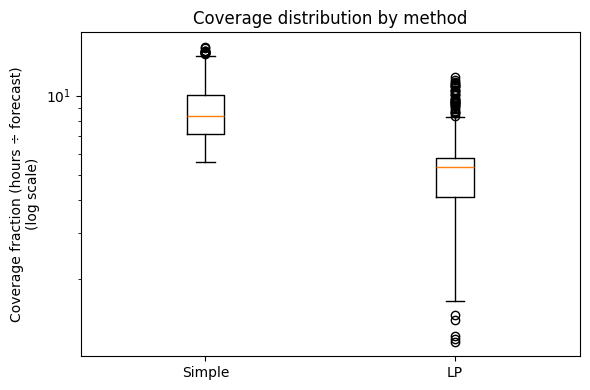

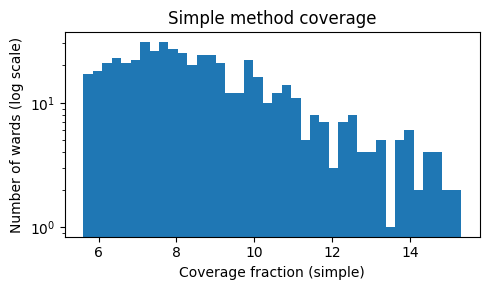

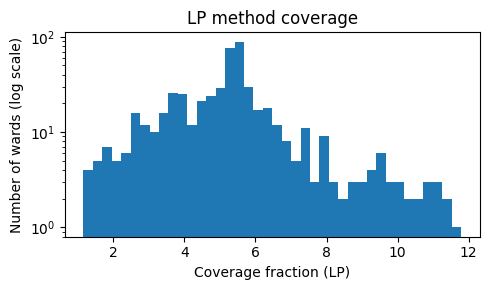

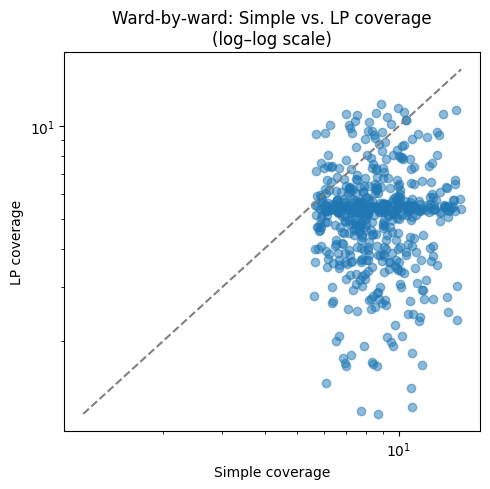

Coverage statistics:
  Minimum coverage       -> Simple: 3.78, LP: 0.22
  Median coverage        -> Simple: 8.41, LP: 5.35
  25th–75th percentile   -> Simple: [7.04, 10.39], LP: [4.02, 6.09]
  95th percentile (tail) -> Simple: 15.38, LP: 11.88


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


simple = pd.read_csv("../data/processed/ward_hour_allocation.csv")
lp     = pd.read_csv("../data/processed/ward_hour_allocation_LP_method.csv")

fc = pd.read_csv("../data/processed/sarima_final_forecast_per_ward.csv", parse_dates=["Month"])
first_month = fc["Month"].min()
fc1 = (
    fc[fc["Month"] == first_month][["Ward code", "mean"]]
      .rename(columns={"mean": "Forecasted_Burglaries"})
)

df = (
    simple[["Ward code", "Allocated_Hours"]]
      .merge(
          lp[["Ward code", "Allocated_Officers_Rounded"]]
            .rename(columns={"Allocated_Officers_Rounded": "LP_Allocated_Hours"}),
          on="Ward code", how="inner"
      )
      .merge(fc1, on="Ward code", how="left")
)

# Compute coverage fractions
df["cov_simple"] = df["Allocated_Hours"]       / df["Forecasted_Burglaries"]
df["cov_lp"]     = df["LP_Allocated_Hours"]    / df["Forecasted_Burglaries"]

# Clean out zeros and infinities
df = df[df["Forecasted_Burglaries"] > 0]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["cov_simple","cov_lp"])

# 5th–95th percentiles for clearer plots
low_s, high_s = df["cov_simple"].quantile([0.05, 0.95])
low_l, high_l = df["cov_lp"].quantile([0.05, 0.95])
mask = (df["cov_simple"].between(low_s, high_s) &
        df["cov_lp"].between(low_l, high_l))
df_trim = df[mask]

# Boxplot
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.boxplot(
    [df_trim["cov_simple"], df_trim["cov_lp"]],
    labels=["Simple","LP"]
)
plt.ylabel("Coverage fraction (hours ÷ forecast)\n(log scale)")
plt.title("Coverage distribution by method")
plt.tight_layout()
plt.show()

#Histograms
plt.figure(figsize=(5,3))
plt.hist(df_trim["cov_simple"], bins=40, log=True)
plt.xlabel("Coverage fraction (simple)")
plt.ylabel("Number of wards (log scale)")
plt.title("Simple method coverage")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.hist(df_trim["cov_lp"], bins=40, log=True)
plt.xlabel("Coverage fraction (LP)")
plt.ylabel("Number of wards (log scale)")
plt.title("LP method coverage")
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(5,5))
plt.xscale("log"); plt.yscale("log")
plt.scatter(df_trim["cov_simple"], df_trim["cov_lp"], alpha=0.5)
vmin = min(df_trim["cov_simple"].min(), df_trim["cov_lp"].min())
vmax = max(df_trim["cov_simple"].max(), df_trim["cov_lp"].max())
plt.plot([vmin, vmax], [vmin, vmax], "--", color="gray")
plt.xlabel("Simple coverage")
plt.ylabel("LP coverage")
plt.title("Ward‐by‐ward: Simple vs. LP coverage\n(log–log scale)")
plt.tight_layout()
plt.show()


# Minimum coverage
min_simple = df["cov_simple"].min()
min_lp     = df["cov_lp"].min()

# Median coverage
median_simple = df["cov_simple"].quantile(0.50)
median_lp     = df["cov_lp"].quantile(0.50)

# 25th and 75th percentiles
q25_simple, q75_simple = df["cov_simple"].quantile([0.25, 0.75])
q25_lp,     q75_lp     = df["cov_lp"].quantile([0.25, 0.75])

# Maximum coverage
max_simple = df["cov_simple"].quantile(0.95)
max_lp     = df["cov_lp"].quantile(0.95)

print("Coverage statistics:")
print(f"  Minimum coverage       -> Simple: {min_simple:.2f}, LP: {min_lp:.2f}")
print(f"  Median coverage        -> Simple: {median_simple:.2f}, LP: {median_lp:.2f}")
print(f"  25th–75th percentile   -> Simple: [{q25_simple:.2f}, {q75_simple:.2f}], LP: [{q25_lp:.2f}, {q75_lp:.2f}]")
print(f"  95th percentile (tail) -> Simple: {max_simple:.2f}, LP: {max_lp:.2f}")
